# Data Mining Final Project - NBA Game Winning Forecasting
## Game Prediction

In [1]:
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

# matplotlib
import matplotlib
import matplotlib.pyplot as plt

## Function - featureEng()

In [2]:
# @param X: pandas.DataFrame
# @param featureSel: int
# @return X: pandas.DataFrame
def featureEng(X, featureSel=None):
    # Feature Engineering
    if not featureSel or featureSel == 0:
        return X
    if featureSel == 1:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
    elif featureSel == 2:
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 3:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 4:
        attriToDrop = [
            'FGM_A', 'FGA_A', '3PM_A', '3PA_A', 'FTM_A', 'FTA_A', 'OREB_A', 'DREB_A', 'PF_A', 
            'FGM_B', 'FGA_B', '3PM_B', '3PA_B', 'FTM_B', 'FTA_B', 'OREB_B', 'DREB_B', 'PF_B'
        ]
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        X['STL+BLK_A'] = X['STL_A'] + X['BLK_A']
        X['STL+BLK_B'] = X['STL_B'] + X['BLK_B']
        attriToDrop += ['PTS_A', 'PTS_B', 'STL_A', 'STL_B', 'BLK_A', 'BLK_B']
        X = X.drop(columns=attriToDrop)
    return X

## Function - featureExtraction()

In [3]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# featureExtraction() outputs X, Y for model training.
def featureExtraction(dfFile, dateStart='1000-01-01', dateEnd='2999-12-31', period=5, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selection
    df = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Get label Y
    Y = df[['W/L_A']]
    Y = Y.rename(columns={'W/L_A': 'Label'})
    
    # Get averaged attributes X
    for idx, row in df.iterrows():
        df_sel = df.loc[df.Date_A <= row['Date_A'], :].reset_index(drop=True)
        
        # Process of Team_A
        gamePlayed_A = df_sel.loc[df_sel.Team_A == row['Team_A'], :]
        if len(gamePlayed_A) == 1:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_A) < period:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_A), 0:24].reset_index(drop=True)
        else:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Process of Team_B
        gamePlayed_B = df_sel.loc[df_sel.Team_A == row['Team_B'], :]
        if len(gamePlayed_B) == 1:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_B) < period:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_B), 0:24].reset_index(drop=True)
        else:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Drop unnecessary attributes
        colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
        X_A = X_A.drop(columns=colToDrop)
        X_B = X_B.drop(columns=colToDrop)
        
        # Rename X_B's columns
        X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
        
        # Get X_single = [Home/Away_A + X_A + X_B]
        X_single = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
        X_single = pd.concat([pd.DataFrame(data={'Home/Away_A': [row['Home/Away_A']]}), X_single], axis=1)
        
        # Concatenation dataFrames by row
        if idx == 0:
            X = X_single
        else:
            X = pd.concat([X, X_single], ignore_index=True)
        
    # Feature Engineering
    X = featureEng(X, featureSel)
        
    return X, Y

## Function - attriGen()

In [4]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str
# @param homeAway: int (None for played game prediction)
# @param featureSel: int
# @return X: pandas.DataFrame
def attriGen(df, date, period, Team_A, Team_B, homeAway=None, featureSel=None):
    # True Home/Away at the game day
    if homeAway is None:
        df_gameDay = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)
        homeAway = int(df_gameDay['Home/Away_A'])
    
    # Date selections
    df = df.loc[df.Date_A < date, :].reset_index(drop=True)
    X_A = df.loc[(df.Team_A == Team_A), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    X_B = df.loc[(df.Team_A == Team_B), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    
    # Drop unnecessary attributes
    colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
    X_A = X_A.drop(columns=colToDrop)
    X_B = X_B.drop(columns=colToDrop)
    
    # Rename X_away's columns
    X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
    
    # Get X = [Home/Away_A + X_A + X_B]
    X = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
    X = pd.concat([pd.DataFrame(data={'Home/Away_A': [homeAway]}), X], axis=1)
    
    # Feature Engineering
    X = featureEng(X, featureSel)
    
    return X

## Function - groundTruthGen()

In [5]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param Team_A, Team_B: str
# @param featureSel: int
# @return X_groundTruth, Y_groundTruth: pandas.DataFrame
def groundTruthGen(df, date, Team_A, Team_B, featureSel=None):
    # Date selections
    df = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)

    # Get label Y
    Y_groundTruth = df[['W/L_A']]
    Y_groundTruth = Y_groundTruth.rename(columns={'W/L_A': 'Label'})
    
    # Drop unnecessary attributes
    colToDrop = [
        'Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A', 
        'Team_B', 'Date_B', 'W/L_B', 'Home/Away_B', 'Score_B', 'Opponent_B'
    ]
    X_groundTruth = df.drop(columns=colToDrop)
    
    # Feature Engineering
    X_groundTruth = featureEng(X_groundTruth, featureSel)
    
    return X_groundTruth, Y_groundTruth

## Function - gameAttriGen()

In [6]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# gameAttriGen() outputs X_attri, Y_truth for game prediction.
def gameAttriGen(dfFile, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selections
    df_sel = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Generate df_sel which includes [date, Team_A, Team_B] columns
    if Team_A and Team_B:
        df_sel = df_sel.loc[(df_sel.Team_A == Team_A) & (df_sel.Opponent_A == Team_B), :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif Team_A and not Team_B:
        df_sel = df_sel.loc[df_sel.Team_A == Team_A, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and Team_B:
        df_sel = df_sel.loc[df_sel.Opponent_A == Team_B, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and not Team_B:
        df_sel = df_sel[['Date_A', 'Team_A', 'Opponent_A']]
        # Delete duplicates: (Team_A vs Team_B) is the same as (Team_B vs Team_A). Remove one to avoid double count.
        df_new = pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'])
        LUT = {}
        for date, x, y in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
            if (date + x + y) in LUT:
                df_new = pd.concat([df_new, pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'], data=[[date, x, y]])], ignore_index=True)
            else:
                LUT[date + x + y] = 1
                LUT[date + y + x] = 1
        df_sel = df_new
    
    # W/L prediction
    X_attri = Y_truth = None
    for date, Team_A, Team_B in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
        X_toBePredicted = attriGen(df, date, period, Team_A, Team_B, None, featureSel)
        X_groundTruth, Y_groundTruth = groundTruthGen(df, date, Team_A, Team_B, featureSel)
        if X_attri is None and Y_truth is None:
            X_attri = X_toBePredicted
            Y_truth = Y_groundTruth
        else:
            X_attri = pd.concat([X_attri, X_toBePredicted], ignore_index=True)
            Y_truth = pd.concat([Y_truth, Y_groundTruth], ignore_index=True)
        
    return X_attri, Y_truth

## Function - gamePrediction()

In [7]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param modelsLUT: dict in the format of {'modelName': model}
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return None
# gamePrediction() prints the predicted game W/L results.
def gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None):
    X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
    
    resultLUT, accuLUT = {}, {}
    for model in modelsLUT:
        resultLUT[model] = modelsLUT[model].predict(X_attri)
        accuLUT[model] = accuracy_score(Y_truth, modelsLUT[model].predict(X_attri))
    
    print('---------- Prediction Accuracy ----------')
    print('featureSel =', featureSel)
    for x in accuLUT:
        print(x, '=', accuLUT[x]*100, '%')
    print('------------------------------------')

## Function - votingGamePrediction()

In [8]:
def votingGamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None, isReport=False):
    X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
    numGame = len(Y_truth)
    
    resultLUT, accuLUT, maxAccuracy = {}, {}, 0
    for model in modelsLUT:
        resultLUT[model] = modelsLUT[model].predict(X_attri)
        accuLUT[model] = accuracy_score(Y_truth, modelsLUT[model].predict(X_attri))
        if accuLUT[model] > maxAccuracy:
            maxAccuracy = accuLUT[model]
            bestModel = model
    
    finalVote = []
    for i in range(0, numGame):
        voteForWin, voteForLoss = 0, 0
        for model in resultLUT:
            if resultLUT[model][i] == 1:
                voteForWin += 1
            else:
                voteForLoss += 1
        if voteForWin > voteForLoss:
            finalVote.append(1)
        elif voteForWin < voteForLoss:
            finalVote.append(0)
        else:
            finalVote.append(resultLUT[bestModel][i])
        if isReport == True:
            print(f'Y_predict={finalVote[i]}(voteForLoss={voteForLoss}, voteForWin={voteForWin}), Y_truth={Y_truth["Label"][i]}')
    
    finalAccuracy = accuracy_score(Y_truth, finalVote)
    print(f'Number of games = {numGame}')
    print(f'Number of models = {len(resultLUT)}')
    print('---------- Prediction Accuracy ----------')
    print(f'Best Model = {bestModel} w/ the accuracy of {accuLUT[bestModel]*100} %')
    print(f'Prediction Accuracy by voting = {finalAccuracy*100} %')
    print('------------------------------------')                

## Function - predictionConf()

In [9]:
def predictionConf(dfFile, modelsLUT, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None):
    X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
    numGame = len(Y_truth)
    
    resultLUT, accuLUT, confLUT, maxAccuracy = {}, {}, {}, 0
    for idx, model in enumerate(modelsLUT):
        resultLUT[model] = modelsLUT[model].predict(X_attri)
        accuLUT[model] = accuracy_score(Y_truth, modelsLUT[model].predict(X_attri))
        confLUT[model] = modelsLUT[model].predict_proba(X_attri)
        if accuLUT[model] > maxAccuracy:
            maxAccuracy = accuLUT[model]
            bestModel = model
        
        # Generate data for report
        col = [model+'_pred', model+'_conf0', model+'_conf1']
        conf_0 = [confLUT[model][i][0] for i in range(0, len(confLUT[model]))]
        conf_1 = [confLUT[model][i][1] for i in range(0, len(confLUT[model]))]
        data = [list(resultLUT[model]), conf_0, conf_1]
        data = list(map(list, zip(*data))) # Transpose
        if idx == 0:
            df_report = pd.concat([Y_truth, pd.DataFrame(data, columns=col)], axis=1)
        else:
            df_report = pd.concat([df_report, pd.DataFrame(data, columns=col)], axis=1)
            
    print(f'Number of games = {numGame}')
    print(f'Number of models = {len(resultLUT)}')
    print('---------- Prediction Accuracy ----------')
    for x in accuLUT:
        print(x, '=', accuLUT[x]*100, '%')
    print('-----------------------------------------')
    
    return df_report

## Function - futureGamePrediction()

In [10]:
def futureGamePrediction(dfFile, modelsLUT, date, period, Team_A, Team_B, homeAway, featureSel):
    df = pd.read_csv(dfFile)
    df_sel = df.loc[df.Date_A == date, :].reset_index(drop=True)

    if df_sel.empty and (homeAway is None):
        print(f'Error: Game not found and Home/Away is not defined.')
        print(f'isEmpty = {df_sel.empty}, HomeAway = {homeAway}')
        print('Force return w/o actions.')
        return None
    
    # Generate the attributes
    X_toBePredicted = attriGen(df, date, period, Team_A, Team_B, homeAway, featureSel)
    
    # Game prediction
    resultLUT = {}
    for model in modelsLUT:
        resultLUT[model] = modelsLUT[model].predict(X_toBePredicted)
    
    # Generate prediction report
    predictList = [resultLUT[x][0] for x in resultLUT]
    voteForWin = sum(predictList)
    voteForLoss = len(predictList) - voteForWin
    col = ['Date', 'Home/Away_A', 'Team_A', 'Team_B'] + list(resultLUT.keys()) + ['Vote for Win', 'Vote for Loss']
    data = [date, homeAway, Team_A, Team_B] + predictList + [voteForWin, voteForLoss] 
    df_report = pd.DataFrame([data], columns=col)
    
    return df_report

## Function - rocCurvePlot()
Reference: 
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py
- https://www.ycc.idv.tw/confusion-matrix.html

In [11]:
def rocCurvePlot(modelsLUT):
    plt.figure(figsize=(25,15))
    color_list = []
    count_item = 10
    
    for name, hex in matplotlib.colors.cnames.items():
        color_list.append(name)

    for model in modelsLUT:
        Y_score = modelsLUT[model].predict_proba(X_attri)[:, 1]
        fpr, tpr, _ = roc_curve(Y_truth, Y_score)
        roc_auc = round(auc(fpr, tpr)*1000)/1000
        # Plot
        plt.plot(fpr, tpr,
                 label=model+'(area:'+str(roc_auc)+')', 
                 color=color_list[count_item], linestyle='-', linewidth=5)
        count_item += 1
    plt.plot([0, 1], [0, 1], 'k--', linewidth=5)
    plt.xlabel('False Positive Rate', fontsize=25)
    plt.ylabel('True Positive Rate', fontsize=25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=25)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=25)
    plt.title('ROC Curve', fontsize=25)
    plt.legend(loc='lower right', fontsize=25)
    plt.grid()
    plt.show()

## Feature Extraction

In [12]:
dfFile = 'nba_preprocessed.csv'
dateStart = '2015-08-01'
dateEnd = '2018-04-13'
period = 5
featureSel = 3
X, Y = featureExtraction(dfFile, dateStart, dateEnd, period, featureSel)

In [13]:
# X

In [14]:
# Y

## Model Training

In [15]:
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

print('>> Logistic Regression ...')
logiRegr = LogisticRegression()
logiRegr.fit(X, Y)
logiRegrCVGS = LogisticRegression(C=100, max_iter=400)
logiRegrCVGS.fit(X, Y)

print('>> SVM ...')
supVecMachine = SVC(kernel='linear', probability=True)
supVecMachine.fit(X, Y)
supVecMachineCVGS = SVC(C=10, kernel='linear', probability=True)
supVecMachineCVGS.fit(X, Y)

print('>> XGBoost ...')
xgbc = XGBClassifier()
xgbc.fit(X, Y)
xgbcCVGS = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, min_child_weight=3, gamma=0.2)
xgbcCVGS.fit(X, Y)

print('>> Naive Bayes ...')
naiveBayes = GaussianNB()
naiveBayes.fit(X, Y)

print('>> Random Forest ...')
randomForest = RandomForestClassifier()
randomForest.fit(X, Y)
randomForestCVGS = RandomForestClassifier(n_estimators=600, criterion='entropy', bootstrap=True, max_depth=None, max_features='sqrt')
randomForestCVGS.fit(X, Y)

print('>> GBDT ...')
gbdt = GradientBoostingClassifier()
gbdt.fit(X,Y)
gbdtCVGS = GradientBoostingClassifier(loss='exponential', n_estimators=600, learning_rate=0.1, max_depth=3, subsample=0.5, max_features='sqrt')
gbdtCVGS.fit(X,Y)

print('>> LightGBM ...')
lgbm = LGBMClassifier()
lgbm.fit(X, Y)
lgbmCVGS = LGBMClassifier(learning_rate=0.1, n_estimators=800, max_depth=-1, subsample=0.5)
lgbmCVGS.fit(X, Y)

print('>> AdaBoost ...')
adaBoost = AdaBoostClassifier()
adaBoost.fit(X, Y)
adaBoostCVGS = AdaBoostClassifier(learning_rate=0.1, n_estimators=1000)
adaBoostCVGS.fit(X, Y)

>> Logistic Regression ...
>> SVM ...
>> XGBoost ...
>> Naive Bayes ...
>> Random Forest ...
>> GBDT ...
>> LightGBM ...
>> AdaBoost ...


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=1000, random_state=None)

In [16]:
modelsLUT = {
    'logiRegr': logiRegr,
    'logiRegrCVGS': logiRegrCVGS,
    'supVecMachine': supVecMachine,
    'supVecMachineCVGS': supVecMachineCVGS,
    'xgbc': xgbc,
    'xgbcCVGS': xgbcCVGS,
    'naiveBayes': naiveBayes,
    'randomForest': randomForest,
    'randomForestCVGS': randomForestCVGS,
    'gbdt': gbdt,
    'gbdtCVGS': gbdtCVGS,
    'lgbm': lgbm,
    'lgbmCVGS': lgbmCVGS, 
    'adaBoost': adaBoost,
    'adaBoostCVGS': adaBoostCVGS
}

## Prediction

### Predictions from all models

In [17]:
dfFile = 'nba_preprocessed.csv'
dateStart = '2018-04-14'
dateEnd = '2018-06-08'
period = 5
Team_A = None
Team_B = None
featureSel = 3

# W/L prediction
gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

---------- Prediction Accuracy ----------
featureSel = 3
logiRegr = 71.95121951219512 %
logiRegrCVGS = 70.73170731707317 %
supVecMachine = 75.60975609756098 %
supVecMachineCVGS = 73.17073170731707 %
xgbc = 73.17073170731707 %
xgbcCVGS = 75.60975609756098 %
naiveBayes = 62.19512195121951 %
randomForest = 69.51219512195121 %
randomForestCVGS = 73.17073170731707 %
gbdt = 74.39024390243902 %
gbdtCVGS = 67.07317073170732 %
lgbm = 69.51219512195121 %
lgbmCVGS = 68.29268292682927 %
adaBoost = 71.95121951219512 %
adaBoostCVGS = 76.82926829268293 %
------------------------------------


### ROC Curve Plotting

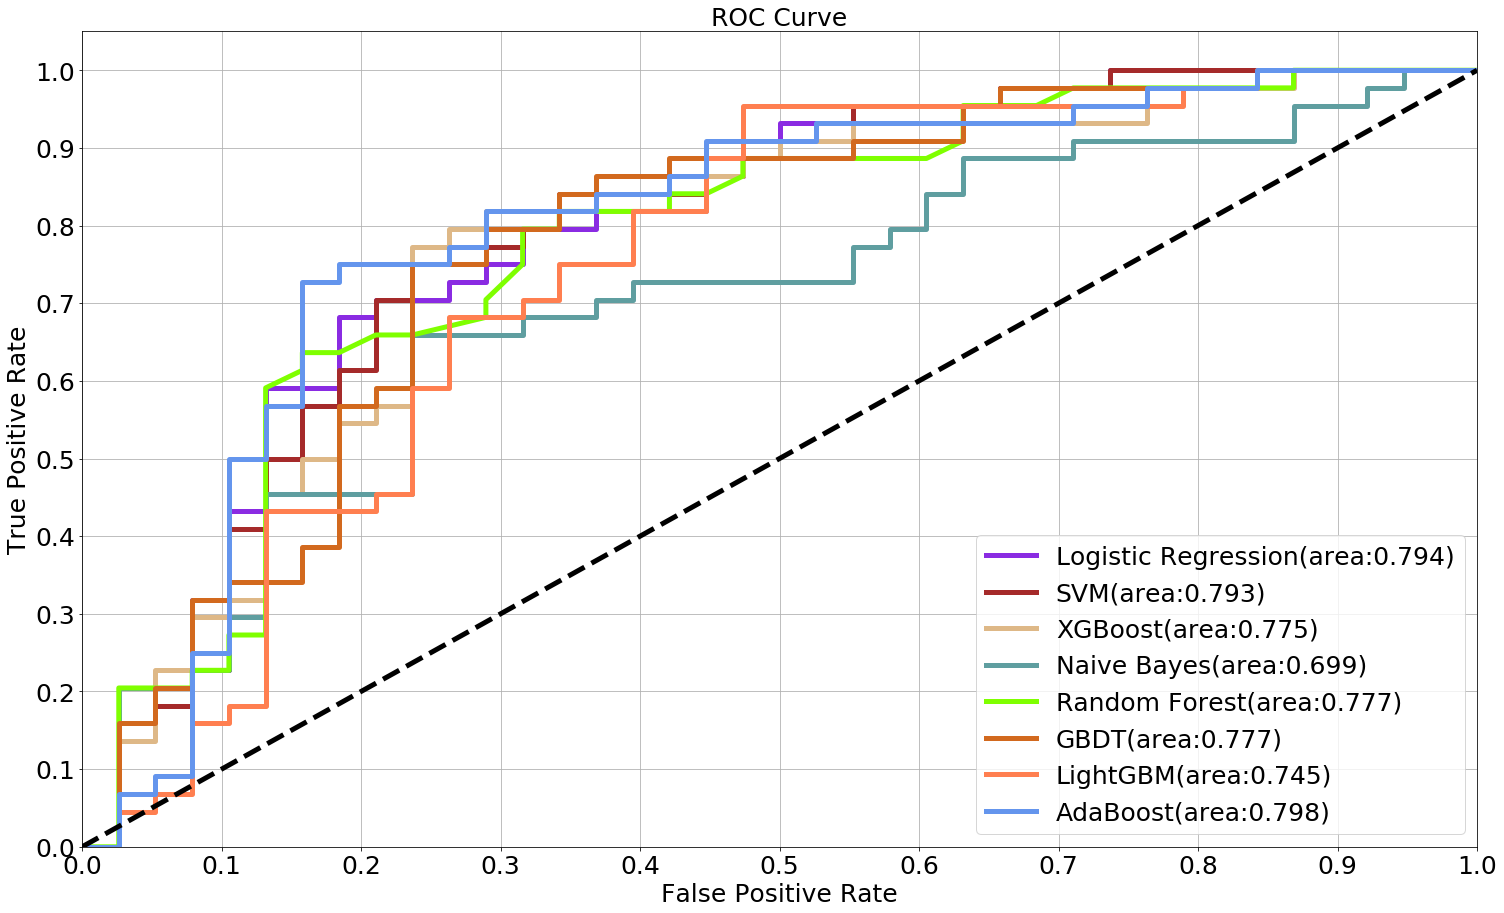

In [45]:
dfFile = 'nba_preprocessed.csv'
dateStart = '2018-04-14'
dateEnd = '2018-06-08'
period = 5
Team_A = None
Team_B = None
featureSel = 3

modelsLUTSel = {
    'Logistic Regression': logiRegr,
    'SVM': supVecMachine,
    'XGBoost': xgbcCVGS,
    'Naive Bayes': naiveBayes,
    'Random Forest': randomForestCVGS,
    'GBDT': gbdt,
    'LightGBM': lgbm, 
    'AdaBoost': adaBoostCVGS
}

X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
rocCurvePlot(modelsLUTSel)